<a href="https://colab.research.google.com/github/AlexandreBrown/AerialSemanticSegmentation/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In [3]:
!pip install torchvision==0.9.0 torch==1.8.0 matplotlib

  Using cached matplotlib-3.4.2-cp39-cp39-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp39-cp39-manylinux1_x86_64.whl (1.2 MB)


# Dependencies

In [42]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import os
%matplotlib inline

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision.datasets import ImageFolder

In [43]:
torch.manual_seed(42)

# Dataset

In [50]:
class SemanticSegmentationOnDiskDataset(Dataset):
    

  def __init__(self, images_path, masks_path, transform=None):
    self.transform = transform
    self.images_path = images_path
    self.image_file_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
    self.image_file_names.sort()
    self.masks_path = masks_path
    self.mask_files_names = [f for f in listdir(masks_path) if isfile(join(masks_path, f))]
    self.mask_files_names.sort()
    print("Directory {0} contains {1} images".format(images_path, len(self.image_file_names)))
    print("Directory {0} contains {1} images".format(masks_path, len(self.mask_files_names)))


  def __len__(self):
    return len(self.image_file_names)


  def __getitem__(self, id):

    img_file_name = self.image_file_names[id]
    img = Image.open(join(self.images_path,img_file_name))  
    
    mask_file_name = self.mask_files_names[id]
    mask = Image.open(join(self.masks_path,mask_file_name))
    
    if self.transform:
        img = self.transform(img)
        mask = self.transform(mask)
    
    return (img, mask)

# Define Visualization Utils

In [51]:
def showImagePair(img1, img2, title ="", scale=False):
    f, (ax1, ax2) = plt.subplots(1,2)
    
    
    image1 = img1.permute(1, 2, 0).detach().numpy()
    image2 = img2.permute(1, 2, 0).detach().numpy()
    
    ax1.set_title(title + " Input", fontsize=20)
    ax1.figure.set_size_inches(20, 20)
    ax1.imshow(image1)
    
    ax2.set_title(title + " Target", fontsize=20)
    ax2.figure.set_size_inches(20, 20)
    ax2.imshow(image2)
    
    plt.tight_layout()
    plt.show()
    

# Load & Preprocess data

Directory ./dataset/train/inputs contains 320 images
Directory ./dataset/train/targets contains 320 images


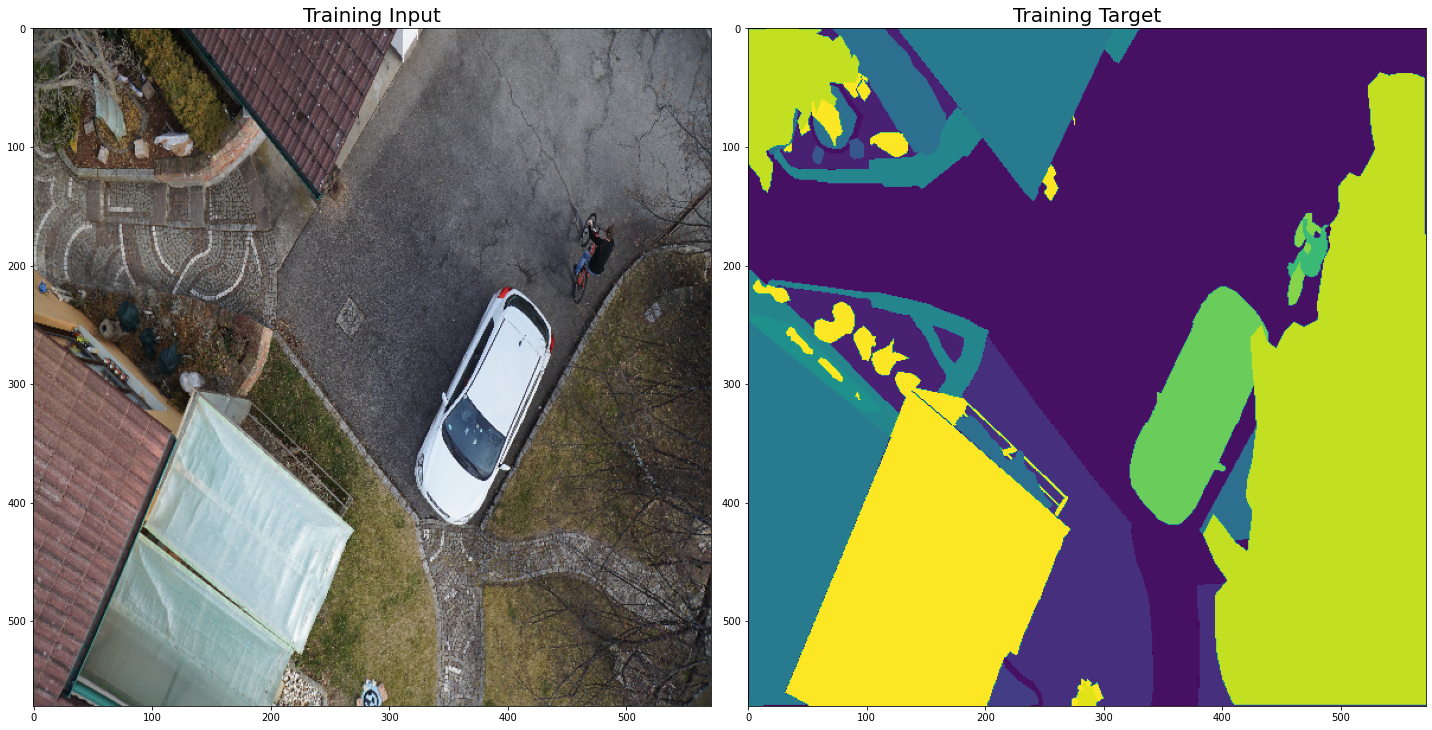

Training dataset shape : torch.Size([3, 572, 572])
Directory ./dataset/test/inputs contains 80 images
Directory ./dataset/test/targets contains 80 images


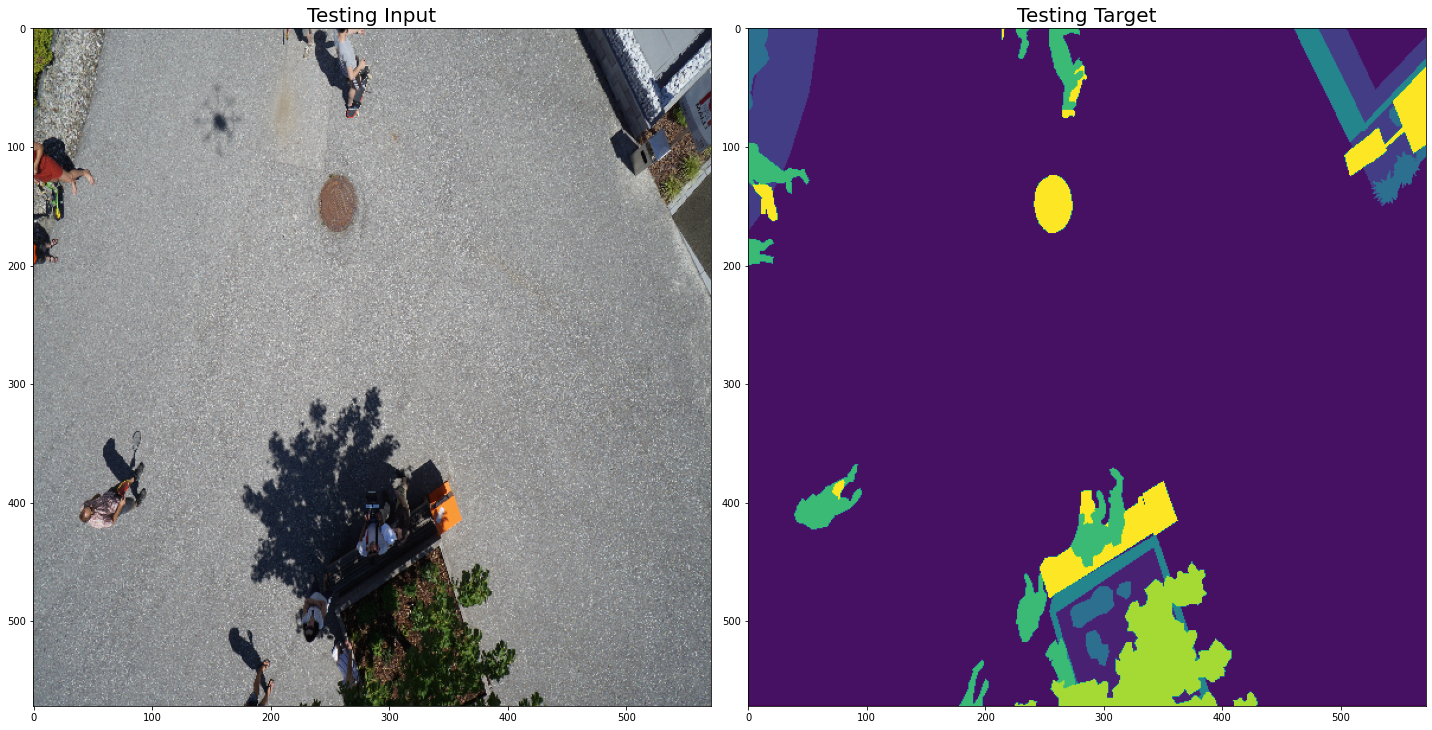

Testing dataset shape : torch.Size([3, 572, 572])


In [86]:
HEIGHT = 572
WIDTH = 572

train_path = "./dataset/train/"
train_images_path = train_path + "inputs"
train_masks_path = train_path + "targets"

train_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH),interpolation=transforms.functional.InterpolationMode.NEAREST), transforms.ToTensor()])
train_dataset = SemanticSegmentationOnDiskDataset(train_images_path, train_masks_path, train_transform)
showImagePair(train_dataset[0][0], train_dataset[0][1], "Training")
print("Training dataset shape : {0}".format(train_dataset[0][0].shape))


train_path = "./dataset/test/"
test_images_path = train_path + "inputs"
test_masks_path = train_path + "targets"

test_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH),interpolation=transforms.functional.InterpolationMode.NEAREST), transforms.ToTensor()])
test_dataset = SemanticSegmentationOnDiskDataset(test_images_path, test_masks_path, test_transform)
showImagePair(test_dataset[0][0], test_dataset[0][1], "Testing")
print("Testing dataset shape : {0}".format(train_dataset[0][0].shape))

# Model

In [129]:
class UNet(nn.Module):
    
    def __init__(self, number_of_classes):
        super(UNet, self).__init__()
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = self.double_conv(3,64)
        self.down_conv_2 = self.double_conv(64,128)
        self.down_conv_3 = self.double_conv(128,256)
        self.down_conv_4 = self.double_conv(256,512)
        self.down_conv_5 = self.double_conv(512,1024)
        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = self.double_conv(1024,512)
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = self.double_conv(512,256)
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = self.double_conv(256,128)
        self.up_transpose_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = self.double_conv(128,64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=number_of_classes, kernel_size=1)


    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
        )
        
        
    def forward(self, image):
        
        # Encoder
        x1 = self.down_conv_1(image) #
        x2 = self.max_pool_2x2(x1)
        
        x3 = self.down_conv_2(x2) #
        x4 = self.max_pool_2x2(x3)
        
        x5 = self.down_conv_3(x4) #
        x6 = self.max_pool_2x2(x5)
        
        x7 = self.down_conv_4(x6) #
        x8 = self.max_pool_2x2(x7)
        
        x9 = self.down_conv_5(x8)
        
        # Decoder
        x = self.up_transpose_1(x9)
        y = self.crop_down(x7, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_1(x)
        
        x = self.up_transpose_2(x)
        y = self.crop_down(x5, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_2(x)
        
        x = self.up_transpose_3(x)
        y = self.crop_down(x3, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_3(x)
        
        x = self.up_transpose_4(x)
        y = self.crop_down(x1, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_4(x)
        
        x = self.out(x)
        
        print(x.shape)
        
        return x
    
    
    def crop_down(self, tensor, target_tensor):
        target_shape = target_tensor.shape[2]
        tensor_shape = tensor.shape[2]
        delta = tensor_shape - target_shape
        delta = delta // 2
        return tensor[:, :, delta:tensor_shape-delta, delta:tensor_shape-delta]

In [131]:
image = torch.randn((1,3,572,572))
model = UNet(number_of_classes=23)

print(model(image))

torch.Size([1, 23, 388, 388])
tensor([[[[-0.1140, -0.1228, -0.1054,  ..., -0.1184, -0.1266, -0.1198],
          [-0.1141, -0.1101, -0.1218,  ..., -0.1097, -0.1252, -0.1168],
          [-0.1124, -0.1037, -0.1093,  ..., -0.1145, -0.1158, -0.1210],
          ...,
          [-0.1133, -0.1044, -0.1217,  ..., -0.1045, -0.1146, -0.1178],
          [-0.1132, -0.1067, -0.1067,  ..., -0.1200, -0.1166, -0.1151],
          [-0.1209, -0.1246, -0.1172,  ..., -0.1101, -0.1140, -0.1112]],

         [[-0.0804, -0.0851, -0.0869,  ..., -0.0799, -0.0927, -0.0903],
          [-0.1013, -0.0990, -0.0780,  ..., -0.0937, -0.0965, -0.0885],
          [-0.0942, -0.0898, -0.0855,  ..., -0.0886, -0.0894, -0.0873],
          ...,
          [-0.0841, -0.0864, -0.0884,  ..., -0.0972, -0.0967, -0.0870],
          [-0.0866, -0.0958, -0.0992,  ..., -0.0845, -0.0916, -0.0823],
          [-0.0938, -0.0921, -0.0929,  ..., -0.0880, -0.0832, -0.0925]],

         [[ 0.0234,  0.0435,  0.0407,  ...,  0.0325,  0.0301,  0.0246],


# Training

In [ ]:
train_batch = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch)

test_batch = 10
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)

number_of_classes=23

model = UNet(number_of_classes)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.003)

n_epochs=3
cost_list=[]
accuracy_list=[]
COST=0

def train_model(n_epochs, model):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            transform = transforms.Compose([transforms.Resize((388, 388),interpolation=transforms.functional.InterpolationMode.NEAREST)])
            y = torch.squeeze(transform(y))
            print("x shape {0}".format(x.shape))
            print("y shape {0}".format(y.shape))
            print("yhat shape {0}".format(yhat.shape))
            print(y)
            print(yhat)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
            
        print("COST {0}".format(COST))
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in test_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            transform = transforms.Compose([transforms.Resize((388, 388),interpolation=transforms.functional.InterpolationMode.NEAREST)])
            correct += (yhat == transform(y_test)).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
train_model(n_epochs, model)